## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import polars as pl

import pickle
import gc

import sklearn.feature_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

import catboost

import warnings
warnings.filterwarnings('ignore')

## 2. Data

In [2]:
df_train = pd.read_csv("/root/kag_comp/UM_MCTS/Data/train.csv")
df_test = pd.read_csv("/root/kag_comp/UM_MCTS/Data/test.csv")
df_concepts = pd.read_csv("/root/kag_comp/UM_MCTS/Data/concepts.csv")

`-` `GameRulesetName`

In [155]:
df_train.GameRulesetName.unique()

array(['00Y', '1D_Chess', '20_SquaresSeleucid_Scholarly', ...,
       'Zurgaan_Tal', 'Zuz_Mel_5x5', 'Zuz_Mel_7x7'], dtype=object)

> `Categorical`로 취급하나, 과적합 우려가 있음

`-` `agent1, agent2`

`MCTS-<SELECTION>-<EXPLORATION_CONST>-<PLAYOUT>-<SCORE_BOUNDS>`

In [3]:
agent1 = df_train.agent1.str.split('-', expand = True).drop(0, axis = 1).rename({1:"Selection1", 2:"EXPLORATION_CONST1", 3:"PLAYOUT1", 4:"SCORE_BOUNDS1"}, axis = 1).assign(SCORE_BOUNDS1 = lambda _df : _df.SCORE_BOUNDS1.map(lambda x : 0 if x == "false" else 1).astype(int))
agent2 = df_train.agent2.str.split('-', expand = True).drop(0, axis = 1).rename({1:"Selection2", 2:"EXPLORATION_CONST2", 3:"PLAYOUT2", 4:"SCORE_BOUNDS2"}, axis = 1).assign(SCORE_BOUNDS2 = lambda _df : _df.SCORE_BOUNDS2.map(lambda x : 0 if x == "false" else 1).astype(int))

## 3. Leaf Node만 적합에 사용(전부 그대로 넣음 : 카테고리컬 변환 미고려)

In [47]:
print(set(df_concepts.Name) - set(df_train.columns[4:808]))
print(set(df_train.columns[4:808]) - set(df_concepts.Name))

{'SkillTrace', 'SkillTraceErrorSlope', 'SkillTraceErrorIntercept', 'SkillTraceScore', 'SkillTraceTrials'}
set()


`-` prediction / submission

In [104]:
## data
X = train_set.loc[:, list(df_concepts.loc[df_concepts.LeafNode == 1].iloc[:-4,].Name)].loc[:, (lambda _df : _df.nunique() != 1)]
y = train_set.utility_agent1
XX = valid_set.loc[:, list(df_concepts.loc[df_concepts.LeafNode == 1].iloc[:-4,].Name)].loc[:, (lambda _df : _df.nunique() != 1)]
yy = valid_set.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor()
predictr.fit(X, y)

Learning rate set to 0.091583
0:	learn: 0.6080964	total: 68.1ms	remaining: 1m 8s
1:	learn: 0.5949551	total: 81.4ms	remaining: 40.6s
2:	learn: 0.5844140	total: 94.7ms	remaining: 31.5s
3:	learn: 0.5752893	total: 170ms	remaining: 42.4s
4:	learn: 0.5671062	total: 185ms	remaining: 36.8s
5:	learn: 0.5596866	total: 199ms	remaining: 32.9s
6:	learn: 0.5532695	total: 273ms	remaining: 38.7s
7:	learn: 0.5472175	total: 286ms	remaining: 35.5s
8:	learn: 0.5424694	total: 360ms	remaining: 39.6s
9:	learn: 0.5383885	total: 373ms	remaining: 36.9s
10:	learn: 0.5340818	total: 387ms	remaining: 34.8s
11:	learn: 0.5309409	total: 462ms	remaining: 38s
12:	learn: 0.5270265	total: 475ms	remaining: 36.1s
13:	learn: 0.5242855	total: 487ms	remaining: 34.3s
14:	learn: 0.5221676	total: 561ms	remaining: 36.8s
15:	learn: 0.5202676	total: 575ms	remaining: 35.4s
16:	learn: 0.5175416	total: 589ms	remaining: 34.1s
17:	learn: 0.5158644	total: 664ms	remaining: 36.2s
18:	learn: 0.5130200	total: 678ms	remaining: 35s
19:	learn: 0

`-` 결과 산출(Validation Set)

In [105]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.21215396422782837
MAE : 0.33394139018424224


kaggle score : 0.547

`-` 추가적으로 고려해볼 사항

In [78]:
## Categorical로 해석해볼 여지가 있는 변수들
X.columns[(X.nunique() > 2) & (X.nunique() <= 10)]

Index(['NumOffDiagonalDirections', 'NumLayers', 'NumPhasesBoard',
       'NumContainers', 'NumDice', 'ProposeDecisionFrequency',
       'PromotionDecisionFrequency', 'StepDecisionToFriendFrequency',
       'SlideDecisionToFriendFrequency', 'LeapDecisionToEnemyFrequency',
       'HopDecisionFriendToFriendFrequency',
       'HopDecisionEnemyToEnemyFrequency', 'HopDecisionFriendToEnemyFrequency',
       'FromToDecisionFrequency', 'ProposeEffectFrequency',
       'PushEffectFrequency', 'FlipFrequency', 'SetCountFrequency',
       'DirectionCaptureFrequency', 'EncloseCaptureFrequency',
       'CustodialCaptureFrequency', 'InterveneCaptureFrequency',
       'SurroundCaptureFrequency', 'NumPlayPhase', 'LineLossFrequency',
       'ConnectionEndFrequency', 'ConnectionLossFrequency',
       'GroupEndFrequency', 'GroupWinFrequency', 'LoopEndFrequency',
       'LoopWinFrequency', 'PatternEndFrequency', 'PatternWinFrequency',
       'NoTargetPieceWinFrequency', 'EliminatePiecesLossFrequency',
     

## 4. Leaf Node의 상위 노드까지 적합에 사용

In [128]:
Leaf_columns = train_set.loc[:, list(df_concepts.loc[df_concepts.LeafNode == 1].iloc[:-4,].Name)].columns
Leaf_Nodes = [{j:i for i, j in enumerate(train_set.columns)}[i] for i in Leaf_columns]
upon_Leaf_Nodes = [i - 1 for i in Leaf_Nodes]

In [132]:
set(df_train.iloc[:, Leaf_Nodes].columns) == set(Leaf_columns)

True

In [137]:
Leaf_Nodes_Plus = list(set(Leaf_Nodes + upon_Leaf_Nodes))

`-` prediction / submission

In [142]:
## data
X = train_set.iloc[:, Leaf_Nodes_Plus].loc[:, (lambda _df : _df.nunique() != 1)]
y = train_set.utility_agent1
XX = valid_set.iloc[:, Leaf_Nodes_Plus].loc[:, (lambda _df : _df.nunique() != 1)]
yy = valid_set.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor()
predictr.fit(X, y)

Learning rate set to 0.091583
0:	learn: 0.6084510	total: 20.4ms	remaining: 20.4s
1:	learn: 0.5953849	total: 36.6ms	remaining: 18.3s
2:	learn: 0.5839730	total: 94.2ms	remaining: 31.3s
3:	learn: 0.5740130	total: 113ms	remaining: 28.3s
4:	learn: 0.5650985	total: 130ms	remaining: 25.8s
5:	learn: 0.5575436	total: 145ms	remaining: 24.1s
6:	learn: 0.5513514	total: 207ms	remaining: 29.3s
7:	learn: 0.5457809	total: 229ms	remaining: 28.4s
8:	learn: 0.5408779	total: 244ms	remaining: 26.9s
9:	learn: 0.5366657	total: 304ms	remaining: 30.1s
10:	learn: 0.5334291	total: 325ms	remaining: 29.3s
11:	learn: 0.5297780	total: 344ms	remaining: 28.3s
12:	learn: 0.5267708	total: 405ms	remaining: 30.8s
13:	learn: 0.5244304	total: 427ms	remaining: 30.1s
14:	learn: 0.5208486	total: 493ms	remaining: 32.4s
15:	learn: 0.5184145	total: 514ms	remaining: 31.6s
16:	learn: 0.5165550	total: 532ms	remaining: 30.8s
17:	learn: 0.5149062	total: 551ms	remaining: 30.1s
18:	learn: 0.5134628	total: 602ms	remaining: 31.1s
19:	lear

`-` 결과 산출

In [143]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.21215902949050297
MAE : 0.33401999062095467


kaggle score : 

> 조금 더 커짐.

## 5. `GameRulesetName`, `agent` 열 포함

`-` 정리

In [10]:
import os
import polars as pl
import numpy as np
import pandas as pd
import catboost
import kaggle_evaluation.mcts_inference_server

target = 'utility_agent1'
counter = 0  # 첫 번째 호출 확인용 변수

def train_model():
    global predictr, columns_list
    df_train = pd.read_csv("/root/kag_comp/UM_MCTS/Data/train.csv")
    df_concepts = pd.read_csv("/root/kag_comp/UM_MCTS/Data/concepts.csv")

    agent1 = df_train.agent1.str.split('-', expand = True).drop(0, axis = 1).rename({1:"Selection1", 2:"EXPLORATION_CONST1", 3:"PLAYOUT1", 4:"SCORE_BOUNDS1"}, axis = 1).assign(SCORE_BOUNDS1 = lambda _df : _df.SCORE_BOUNDS1.map(lambda x : 0 if x == "false" else 1).astype(int))
    agent2 = df_train.agent2.str.split('-', expand = True).drop(0, axis = 1).rename({1:"Selection2", 2:"EXPLORATION_CONST2", 3:"PLAYOUT2", 4:"SCORE_BOUNDS2"}, axis = 1).assign(SCORE_BOUNDS2 = lambda _df : _df.SCORE_BOUNDS2.map(lambda x : 0 if x == "false" else 1).astype(int))
    
    categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]
    
    df_preprocessed = pd.concat([df_train.drop(["Id", "agent1", "agent2"], axis = 1), agent1, agent2], axis = 1).drop(["EnglishRules", "LudRules", "num_wins_agent1", "num_draws_agent1", "num_losses_agent1"], axis = 1)
    
    X = df_preprocessed.loc[:, list(df_concepts.loc[df_concepts.LeafNode == 1].iloc[:-4,].Name) + categorical_features].loc[:, (lambda _df : _df.nunique() != 1)]
    y = df_train[target]

    predictr = catboost.CatBoostRegressor(cat_features = categorical_features)
    predictr.fit(X, y)

    columns_list = X.columns

def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    global counter
    if counter == 0:  # 첫 번째 호출 시에만 모델을 학습하거나 로드
        train_model()
        counter += 1

    df_test = test.to_pandas()

    agent1 = df_test.agent1.str.split('-', expand = True).drop(0, axis = 1).rename({1:"Selection1", 2:"EXPLORATION_CONST1", 3:"PLAYOUT1", 4:"SCORE_BOUNDS1"}, axis = 1).assign(SCORE_BOUNDS1 = lambda _df : _df.SCORE_BOUNDS1.map(lambda x : 0 if x == "false" else 1).astype(int))
    agent2 = df_test.agent2.str.split('-', expand = True).drop(0, axis = 1).rename({1:"Selection2", 2:"EXPLORATION_CONST2", 3:"PLAYOUT2", 4:"SCORE_BOUNDS2"}, axis = 1).assign(SCORE_BOUNDS2 = lambda _df : _df.SCORE_BOUNDS2.map(lambda x : 0 if x == "false" else 1).astype(int))

    df_preprocessed = pd.concat([df_test.drop(["Id", "agent1", "agent2"], axis = 1), agent1, agent2], axis = 1).drop(["EnglishRules", "LudRules"], axis = 1)
    
    predictions = pd.Series(predictr.predict(df_preprocessed.loc[:, columns_list]))
    return sample_sub.with_columns(pl.Series('utility_agent1', predictions))

# 인퍼런스 서버 설정
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/root/kag_comp/UM_MCTS/Data/test.csv',
            '/root/kag_comp/UM_MCTS/Data/sample_submission.csv'
        )
    )

Learning rate set to 0.096893
0:	learn: 0.5993034	total: 111ms	remaining: 1m 50s
1:	learn: 0.5792127	total: 301ms	remaining: 2m 30s
2:	learn: 0.5616254	total: 407ms	remaining: 2m 15s
3:	learn: 0.5461809	total: 516ms	remaining: 2m 8s
4:	learn: 0.5339704	total: 619ms	remaining: 2m 3s
5:	learn: 0.5226961	total: 716ms	remaining: 1m 58s
6:	learn: 0.5136710	total: 836ms	remaining: 1m 58s
7:	learn: 0.5058516	total: 936ms	remaining: 1m 56s
8:	learn: 0.4993039	total: 1.11s	remaining: 2m 2s
9:	learn: 0.4919829	total: 1.22s	remaining: 2m
10:	learn: 0.4874967	total: 1.32s	remaining: 1m 59s
11:	learn: 0.4829586	total: 1.43s	remaining: 1m 57s
12:	learn: 0.4779020	total: 1.6s	remaining: 2m 1s
13:	learn: 0.4746928	total: 1.72s	remaining: 2m
14:	learn: 0.4700839	total: 1.9s	remaining: 2m 4s
15:	learn: 0.4648112	total: 2.01s	remaining: 2m 3s
16:	learn: 0.4602689	total: 2.2s	remaining: 2m 7s
17:	learn: 0.4558127	total: 2.31s	remaining: 2m 5s
18:	learn: 0.4521816	total: 2.41s	remaining: 2m 4s
19:	learn: 0

In [4]:
df_preprocessed = pd.concat([df_train.drop(["Id", "agent1", "agent2"], axis = 1), agent1, agent2], axis = 1).drop(["EnglishRules", "LudRules", "num_wins_agent1", "num_draws_agent1", "num_losses_agent1"], axis = 1)

In [5]:
df_preprocessed.head()

,GameRulesetName,Properties,Format,Time,Discrete,Realtime,Turns,Alternating,Simultaneous,Stochastic,...,MovesPerSecond,utility_agent1,Selection1,EXPLORATION_CONST1,PLAYOUT1,SCORE_BOUNDS1,Selection2,EXPLORATION_CONST2,PLAYOUT2,SCORE_BOUNDS2
0,00Y,1,1,1,1,0,1,1,0,0,...,18877.17,-0.466667,ProgressiveHistory,0.1,MAST,0,ProgressiveHistory,0.6,Random200,0
1,00Y,1,1,1,1,0,1,1,0,0,...,18877.17,-0.333333,ProgressiveHistory,0.1,MAST,0,UCB1GRAVE,0.6,NST,1
2,00Y,1,1,1,1,0,1,1,0,0,...,18877.17,-0.066667,ProgressiveHistory,0.1,MAST,1,UCB1,0.1,NST,0
3,00Y,1,1,1,1,0,1,1,0,0,...,18877.17,-0.333333,ProgressiveHistory,0.1,MAST,1,UCB1,0.6,NST,0
4,00Y,1,1,1,1,0,1,1,0,0,...,18877.17,-0.333333,ProgressiveHistory,0.1,MAST,1,UCB1GRAVE,1.41421356237,NST,0


`-` Leaf Node만

In [26]:
train_set, valid_set = sklearn.model_selection.train_test_split(df_preprocessed, test_size = 0.3, shuffle = True, random_state = 14107)

In [221]:
## categorical features
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## data
X = train_set.loc[:, list(df_concepts.loc[df_concepts.LeafNode == 1].iloc[:-4,].Name) + categorical_features].loc[:, (lambda _df : _df.nunique() != 1)]
y = train_set.utility_agent1
XX = valid_set.loc[:, X.columns]
yy = valid_set.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor(cat_features = categorical_features)
predictr.fit(X, y)

Learning rate set to 0.091583
0:	learn: 0.6006769	total: 171ms	remaining: 2m 51s
1:	learn: 0.5815502	total: 295ms	remaining: 2m 27s
2:	learn: 0.5649836	total: 459ms	remaining: 2m 32s
3:	learn: 0.5508555	total: 559ms	remaining: 2m 19s
4:	learn: 0.5385647	total: 675ms	remaining: 2m 14s
5:	learn: 0.5275642	total: 771ms	remaining: 2m 7s
6:	learn: 0.5185444	total: 864ms	remaining: 2m 2s
7:	learn: 0.5109108	total: 971ms	remaining: 2m
8:	learn: 0.5027130	total: 1.08s	remaining: 1m 59s
9:	learn: 0.4971589	total: 1.17s	remaining: 1m 56s
10:	learn: 0.4920925	total: 1.27s	remaining: 1m 54s
11:	learn: 0.4868932	total: 1.4s	remaining: 1m 55s
12:	learn: 0.4825358	total: 1.56s	remaining: 1m 58s
13:	learn: 0.4781250	total: 1.66s	remaining: 1m 56s
14:	learn: 0.4738999	total: 1.78s	remaining: 1m 56s
15:	learn: 0.4699943	total: 1.88s	remaining: 1m 55s
16:	learn: 0.4661957	total: 2.07s	remaining: 1m 59s
17:	learn: 0.4616402	total: 2.18s	remaining: 1m 59s
18:	learn: 0.4580428	total: 2.28s	remaining: 1m 57s

`-` 결과 산출

In [222]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.08195822171983654
MAE : 0.2112922702155526


kaggle : 0.465

`-` `agent1/agent2`를 그대로 적합 (당연히 별로였음)

In [24]:
## categorical features
categorical_features = ["GameRulesetName", "agent1", "agent2"]

## data
X = train_set.loc[:, list(df_concepts.loc[df_concepts.LeafNode == 1].iloc[:-4,].Name) + categorical_features].loc[:, (lambda _df : _df.nunique() != 1)]
y = train_set.utility_agent1
XX = valid_set.loc[:, X.columns]
yy = valid_set.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor(cat_features = categorical_features)
predictr.fit(X, y)

Learning rate set to 0.091583
0:	learn: 0.5995679	total: 161ms	remaining: 2m 40s
1:	learn: 0.5797745	total: 296ms	remaining: 2m 27s
2:	learn: 0.5623970	total: 403ms	remaining: 2m 13s
3:	learn: 0.5468766	total: 476ms	remaining: 1m 58s
4:	learn: 0.5339088	total: 566ms	remaining: 1m 52s
5:	learn: 0.5219289	total: 691ms	remaining: 1m 54s
6:	learn: 0.5122079	total: 860ms	remaining: 2m 1s
7:	learn: 0.5034766	total: 965ms	remaining: 1m 59s
8:	learn: 0.4956206	total: 987ms	remaining: 1m 48s
9:	learn: 0.4887155	total: 1.09s	remaining: 1m 47s
10:	learn: 0.4829680	total: 1.21s	remaining: 1m 49s
11:	learn: 0.4776109	total: 1.28s	remaining: 1m 45s
12:	learn: 0.4727561	total: 1.46s	remaining: 1m 50s
13:	learn: 0.4681697	total: 1.56s	remaining: 1m 50s
14:	learn: 0.4650590	total: 1.67s	remaining: 1m 49s
15:	learn: 0.4614410	total: 1.79s	remaining: 1m 50s
16:	learn: 0.4587712	total: 1.98s	remaining: 1m 54s
17:	learn: 0.4557506	total: 2.07s	remaining: 1m 53s
18:	learn: 0.4532653	total: 2.26s	remaining: 

In [25]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.10555606915038909
MAE : 0.23822239283463625


## 6. Features Selection

`-` **리프 노드**

In [6]:
Leaf_columns = df_preprocessed.loc[:, list(df_concepts.loc[df_concepts.LeafNode == 1].iloc[:-4,].Name)].columns
Leaf_Nodes = [{j:i for i, j in enumerate(df_preprocessed.columns)}[i] for i in Leaf_columns]

In [7]:
df_selection = df_preprocessed.iloc[:, [0] + Leaf_Nodes + list(range(806, 814))].loc[:, (lambda _df : _df.nunique() != 1)]
df_concepts.iloc[[i for i, f in enumerate(df_concepts.Name) if f in list(set(df_concepts.Name) & set(df_selection.columns))], :].LeafNode.unique()

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # KFold 설정

In [15]:
## categorical features
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## data
X = df_selection
y = df_train.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor(cat_features = categorical_features)
predictr.fit(X, y)

Learning rate set to 0.096893
0:	learn: 0.5994261	total: 169ms	remaining: 2m 49s
1:	learn: 0.5795693	total: 276ms	remaining: 2m 17s
2:	learn: 0.5626449	total: 380ms	remaining: 2m 6s
3:	learn: 0.5471605	total: 570ms	remaining: 2m 22s
4:	learn: 0.5347823	total: 670ms	remaining: 2m 13s
5:	learn: 0.5239649	total: 789ms	remaining: 2m 10s
6:	learn: 0.5134128	total: 906ms	remaining: 2m 8s
7:	learn: 0.5055834	total: 1.07s	remaining: 2m 12s
8:	learn: 0.4972145	total: 1.19s	remaining: 2m 11s
9:	learn: 0.4908209	total: 1.36s	remaining: 2m 15s
10:	learn: 0.4848304	total: 1.48s	remaining: 2m 13s
11:	learn: 0.4798327	total: 1.66s	remaining: 2m 17s
12:	learn: 0.4754708	total: 1.77s	remaining: 2m 14s
13:	learn: 0.4711035	total: 1.89s	remaining: 2m 13s
14:	learn: 0.4681044	total: 2.06s	remaining: 2m 15s
15:	learn: 0.4625062	total: 2.2s	remaining: 2m 15s
16:	learn: 0.4579027	total: 2.38s	remaining: 2m 17s
17:	learn: 0.4536586	total: 2.58s	remaining: 2m 20s
18:	learn: 0.4499811	total: 2.68s	remaining: 2m

In [46]:
importances_list = {i:j for i, j in zip(predictr.feature_names_, predictr.feature_importances_) if j > 0.0}

with open('important_list_leafs.pkl', 'wb') as f :
    pickle.dump(importances_list, f)

In [81]:
pd.Series(predictr.feature_importances_).describe()

count    423.000000
mean       0.236407
std        2.060880
min        0.000000
25%        0.000000
50%        0.008230
75%        0.048746
max       40.753074
dtype: float64

In [86]:
pd.Series(predictr.feature_importances_).loc[lambda _df : _df != 0.0].describe()

count    279.000000
mean       0.358423
std        2.530482
min        0.000287
25%        0.008543
50%        0.025735
75%        0.095771
max       40.753074
dtype: float64

* 디폴트로 사용

In [17]:
sfm = sklearn.feature_selection.SelectFromModel(predictr)
X_selected = sfm.transform(X)

# 선택된 변수 확인
selected_features = sfm.get_support(indices=True)
print("선택된 변수:", X.columns[selected_features])

선택된 변수: Index(['GameRulesetName', 'AsymmetricPiecesType', 'NumVertices',
       'NumPlayableSites', 'NumComponentsType', 'SowCCW',
       'HopCaptureFrequency', 'DurationActions', 'DurationMoves',
       'DurationTurns', 'DecisionMoves', 'GameTreeComplexity',
       'StateTreeComplexity', 'AdvantageP1', 'Balance', 'Completion',
       'Drawishness', 'BoardSitesOccupiedChangeLineBestFit',
       'BoardSitesOccupiedMaxIncrease', 'BoardSitesOccupiedMaxDecrease',
       'BranchingFactorAverage', 'BranchingFactorMedian',
       'BranchingFactorMaximum', 'DecisionFactorAverage',
       'DecisionFactorMedian', 'DecisionFactorChangeSign', 'PlayoutsPerSecond',
       'MovesPerSecond', 'OutcomeUniformity', 'Selection1',
       'EXPLORATION_CONST1', 'PLAYOUT1', 'Selection2', 'EXPLORATION_CONST2',
       'PLAYOUT2'],
      dtype='object')


In [32]:
## categorical features
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## data
X = df_selection.iloc[:, selected_features]
y = df_train.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor(cat_features=list(set(df_selection.columns[selected_features]) & set(categorical_features)), 
                          verbose=0, random_state=42, task_type = "GPU", devices = "0")

score = np.mean(cross_val_score(predictr, X, y, cv=kf, scoring='neg_mean_absolute_error'))

In [34]:
print(f"MAE(5-fold) : {-score}")

MAE(5-fold) : 0.21331190097224403


In [134]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.22590531726149443
MAE : 0.35707227518481416


* median value까지만 사용

In [ ]:
with open('important_list_leafs.pkl', 'rb') as f :
    important_features = pickle.load(f)

In [36]:
selected_features = [i for i, j in importances_list.items() if j >= 0.025735]

# with open('important_features.pkl', 'wb') as f :
#     pickle.dump(selected_features, f)

In [39]:
## categorical features
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## data
X = df_selection.loc[:, selected_features]
y = df_train.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor(cat_features=list(set(selected_features) & set(categorical_features)), 
                          verbose=0, random_state=42, task_type = "GPU", devices = "0")

score = np.mean(cross_val_score(predictr, X, y, cv=kf, scoring='neg_mean_absolute_error'))

In [40]:
print(f"MAE(5-fold) : {-score}")

MAE(5-fold) : 0.21251981321584293


In [107]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.08119616236659027
MAE : 0.21010928483194624


* 1q까지 사용

In [169]:
with open("/root/kag_comp/UM_MCTS/important_features.pkl", "wb") as f :
    pickle.dump(selected_features, f)

In [166]:
selected_features = [i for i, j in importances_list.items() if j >= 0.095771]

In [41]:
## categorical features
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## data
X = df_selection.loc[:, selected_features]
y = df_train.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor(cat_features=list(set(selected_features) & set(categorical_features)), 
                          verbose=0, random_state=42, task_type = "GPU", devices = "0")

score = np.mean(cross_val_score(predictr, X, y, cv=kf, scoring='neg_mean_absolute_error'))

In [42]:
print(f"MAE(5-fold) : {-score}")

MAE(5-fold) : 0.21263669946906213


In [114]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.08097459994069353
MAE : 0.20976085283597642


* 3q까지 사용

In [47]:
selected_features = [i for i, j in importances_list.items() if j >= 0.008543]

In [48]:
## categorical features
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## data
X = df_selection.loc[:, selected_features]
y = df_train.utility_agent1

## predictor
predictr = catboost.CatBoostRegressor(cat_features=list(set(selected_features) & set(categorical_features)), 
                          verbose=0, random_state=42, task_type = "GPU", devices = "0")

score = np.mean(cross_val_score(predictr, X, y, cv=kf, scoring='neg_mean_absolute_error'))

In [49]:
print(f"MAE(5-fold) : {-score}")

MAE(5-fold) : 0.21297807036391608


In [117]:
print(f"MSE : {np.mean((yy - predictr.predict(XX))**2)}")
print(f"MAE : {np.mean(abs(yy - predictr.predict(XX)))}")

MSE : 0.08179517412674288
MAE : 0.21116248766107693


`-` Cross Validation (최적의 열 개수 선택)

In [ ]:
# 데이터 준비
X = df_preprocessed.drop("utility_agent1", axis = 1)  # 입력 데이터 (DataFrame)
y = df_preprocessed.utility_agent1  # 타겟 변수
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

# Feature Importance 가져오기
with open('important_list_leafs.pkl', 'rb') as f :
    importances_list = pickle.load(f)

feature_importances = importances_list.values()
feature_names = importances_list.keys()
sorted_features = [x for _, x in sorted(zip(feature_importances, feature_names), reverse=True)]

In [ ]:
# 2. CV를 위한 초기화
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # KFold 설정
selected_features = []  # 현재 선택된 변수
cv_results = []  # CV 결과 저장
score_list = []
dumb_list = []

# 3. Feature Importance 순서대로 변수 추가하며 CV
for f in sorted_features :
    selected_features.append(f)
    X_subset = X[selected_features]  # 선택된 변수만 사용
    
    # CatBoost 모델 설정
    model = catboost.CatBoostRegressor(cat_features=[selected_features.index(f) for f in selected_features if f in categorical_features], 
                              verbose=0, random_state=42, task_type = "GPU", devices = "0")
    
    # 교차 검증 수행
    score = np.mean(cross_val_score(model, X_subset, y, cv=kf, scoring='neg_mean_absolute_error'))
    cv_results.append((selected_features.copy(), score))
    score_list.append(score)

    if len(score_list) >= 2 :
        if (score_list[-2] > score_list[-1]) :
            dumb_list.append(f)
            print("추가하여 성능이 떨어졌음")
    
    print(f"추가된 변수: {f}, 현재 CV 점수: {score}")
    print(f"현재 변수 : {selected_features}")

추가된 변수: GameRulesetName, 현재 CV 점수: -0.3884880499838338
현재 변수 : ['GameRulesetName']
추가된 변수: Selection1, 현재 CV 점수: -0.375650667332234
현재 변수 : ['GameRulesetName', 'Selection1']
추가된 변수: Selection2, 현재 CV 점수: -0.34528894565495766
현재 변수 : ['GameRulesetName', 'Selection1', 'Selection2']
추가된 변수: EXPLORATION_CONST1, 현재 CV 점수: -0.32417108539868933
현재 변수 : ['GameRulesetName', 'Selection1', 'Selection2', 'EXPLORATION_CONST1']
추가된 변수: EXPLORATION_CONST2, 현재 CV 점수: -0.30421423333813513
현재 변수 : ['GameRulesetName', 'Selection1', 'Selection2', 'EXPLORATION_CONST1', 'EXPLORATION_CONST2']
추가된 변수: PLAYOUT1, 현재 CV 점수: -0.28819318768054225
현재 변수 : ['GameRulesetName', 'Selection1', 'Selection2', 'EXPLORATION_CONST1', 'EXPLORATION_CONST2', 'PLAYOUT1']
추가된 변수: PLAYOUT2, 현재 CV 점수: -0.26806647185352805
현재 변수 : ['GameRulesetName', 'Selection1', 'Selection2', 'EXPLORATION_CONST1', 'EXPLORATION_CONST2', 'PLAYOUT1', 'PLAYOUT2']
추가된 변수: AdvantageP1, 현재 CV 점수: -0.23229263855507926
현재 변수 : ['GameRulesetName', 'Selectio

`-` Best set

In [193]:
score_board = {i:j for i, j in zip(sorted_features[51:104], score_list)}

with open("score_board.pkl", "wb") as f :
    pickle.dump(score_board, f)

In [39]:
with open("current.pkl", "rb") as f :
    current_lists = pickle.load(f)

In [89]:
np.where(current_lists[0] == max(current_lists[0]))

(array([84]),)

In [83]:
max(current_lists[0])

-0.21151289423559802

kaggle : 0.466

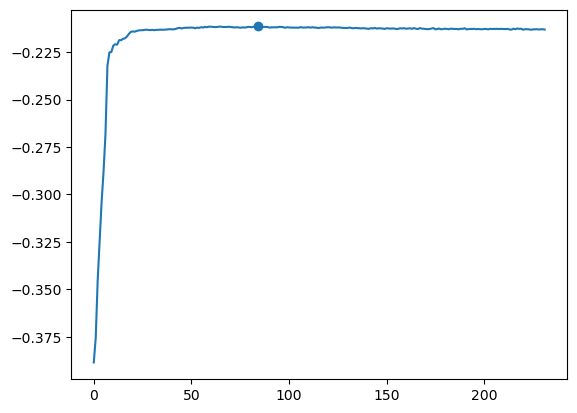

In [160]:
import matplotlib.pyplot as plt

plt.plot(current_lists[0])
plt.scatter([84], [-0.21151289423559802])
plt.show()

`-` Best set - Dump list

In [166]:
important_var = list(set(sorted_features[:85]) - set(dumb_list))

In [169]:
# 데이터 준비
X = df_preprocessed.drop("utility_agent1", axis = 1).loc[:, important_var]  # 입력 데이터 (DataFrame)
y = df_preprocessed.utility_agent1  # 타겟 변수
    
# CatBoost 모델 설정
model = catboost.CatBoostRegressor(cat_features=list(set(important_var) & set(categorical_features)), verbose=0, random_state=42, task_type = "GPU", devices = "0")

# 교차 검증 수행
score = np.mean(cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error'))
best_mae = score

print(f"MAE : {score}")

MAE : -0.2121049843851514


> 전부 다 빼는 것은 성능 저하

### Cross Validation of exception

In [44]:
with open("current.pkl", "rb") as f :
    current_lists = pickle.load(f)

with open('important_list_leafs.pkl', 'rb') as f :
    important_features = pickle.load(f)

In [67]:
feature_importances = important_features.values()
feature_names = important_features.keys()
sorted_features = [x for _, x in sorted(zip(feature_importances, feature_names), reverse=True)]
dumb_list = current_lists[1]

In [85]:
dump_list[17:]

['EliminatePiecesWinFrequency',
 'BoardSitesOccupiedMaximum',
 'DecisionFactorMaxIncrease',
 'NumPlayableSitesOnBoard',
 'SowOriginFirst',
 'BoardSitesOccupiedChangeLineBestFit',
 'StateTreeComplexity',
 'NumPlayableSites',
 'DecisionFactorAverage',
 'MovesPerSecond',
 'AsymmetricPiecesType',
 'Balance']

In [86]:
## 데이터 준비
X = df_preprocessed.drop("utility_agent1", axis = 1)
y = df_train.utility_agent1

categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## 버릴 변수 후보
dump_list = [dumb_list[len(dumb_list)-i-1] for i in range(len(dumb_list))] ## inverse
dump_list = [f for f in dump_list if f in sorted_features[:85]]

## 초기화
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # KFold 설정
selected_features = sorted_features[:85]  # 현재 선택된 변수
score_list = [max(current_lists[0])]  ## best mae

## 역순으로 변수 제거하며 CV(중간에 끊었었음)
for f in dump_list[:17] :
    X_subset = X[list(set(selected_features) - set(f))]  # 선택된 변수만 사용
    
    # CatBoost 모델 설정
    model = catboost.CatBoostRegressor(cat_features=list(set(X_subset.columns) & set(categorical_features)), verbose=0, random_state=42, task_type = "GPU", devices = "0")
    
    # 교차 검증 수행
    score = np.mean(cross_val_score(model, X_subset, y, cv=kf, scoring='neg_mean_absolute_error'))

    if score > score_list[-1] :
        selected_features = list(set(selected_features) - set(f))
        score_list.append(score)
        print(f"변수 {f}를 제거하여 성능이 향상됨, 현재 CV 점수 : {score}")
    else :
        print(f"변수 {f} 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : {score_list[-1]}")

변수 NumDirections 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 MorrisTiling 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 EliminatePiecesEndFrequency 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 SCORE_BOUNDS2 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 NumStartComponentsPerPlayer 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 NumPlayPhase 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 BranchingFactorChangeAverage 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 MoveDistanceChangeAverage 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 DecisionFactorMaxDecrease 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 NumStartComponentsHand 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 PieceNumberMedian 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 NumPerimeterSites 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.21151289423559802
변수 LineWinFrequency 제거로 성능이 떨어짐, 제거하지 않음. 현재 CV 점수 : -0.2115128942

> 일단 제거할 변수는 없었음. 리프 노드 선택 종료

In [90]:
with open("Important_Leafs.pkl", "wb") as f :
    pickle.dump(selected_features, f)

### **리프 노드 + 상위 노드**

In [91]:
upon_Leaf_Nodes = list(set([i - 1 for i in Leaf_Nodes]) - set(Leaf_Nodes))
Leaf_Nodes_Plus = Leaf_Nodes + upon_Leaf_Nodes

In [134]:
leafs_df = df_preprocessed.loc[:, selected_features]
upon_leafs_df = df_preprocessed.iloc[:, upon_Leaf_Nodes].loc[:, (lambda _df : _df.nunique() != 1)]

`-` 전부 추가

In [139]:
## data
X = pd.concat([leafs_df, upon_leafs_df], axis = 1)
cat_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # KFold 설정
predictr = catboost.CatBoostRegressor(cat_features=list(set(X.columns) & set(categorical_features)), verbose=0, random_state=42, task_type = "GPU", devices = "0")
score = np.mean(cross_val_score(predictr, X, y, cv = kf, scoring = "neg_mean_absolute_error"))

print(f"전부 추가했을 때의 MAE 예측값 : {score}")

전부 추가했을 때의 MAE 예측값 : -0.21245962629101736


> 전부 추가했을 때, 예측 성능은 현저히 감소하였음.

In [140]:
## importances 산출
predictr = catboost.CatBoostRegressor(cat_features=list(set(X.columns) & set(categorical_features)), verbose=0, random_state=42, task_type = "GPU", devices = "0")
predictr.fit(X, y)

importances_list = {i:j for i, j in zip(predictr.feature_names_, predictr.feature_importances_) if j > 0.0}

In [142]:
pd.Series(predictr.feature_importances_).describe()

count    250.000000
mean       0.400000
std        2.138465
min        0.000000
25%        0.000827
50%        0.012676
75%        0.156459
max       30.697817
dtype: float64

In [143]:
pd.Series(predictr.feature_importances_).loc[lambda _df : _df != 0.0].describe()

count    196.000000
mean       0.510204
std        2.404765
min        0.000207
25%        0.005715
50%        0.032000
75%        0.224574
max       30.697817
dtype: float64

In [171]:
len(importances_list.keys())

196

In [175]:
additional_list = {k:v for k, v in importances_list.items() if k not in selected_features}
additional_features = [k for v, k in sorted(zip(additional_list.values(), additional_list.keys()), reverse = True)] ## 중요도에 따라 역으로 정렬

with open("additional_features.pkl", "wb") as f :
    pickle.dump(additional_features, f)

`-` 최적의 열 개수 선택

현재 변수 추가 시 score_list를 초기화하지 않아 문제가 있으니, 주의 바람

In [177]:
## data
X = pd.concat([leafs_df, upon_leafs_df], axis = 1)
categorical_features = ["GameRulesetName", "Selection1", "Selection2", "EXPLORATION_CONST1", "EXPLORATION_CONST2", "PLAYOUT1", "PLAYOUT2"]

## 중요도 순으로 정렬된 피쳐명 가져오기
with open("additional_features.pkl", "rb") as f :
    additional_features = pickle.load(f)

with open("Important_Leafs.pkl", "rb") as f :
    selected_features = pickle.load(f)

## 초기화
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # KFold 설정
added_features = []  ## 현재 추가된 변수
cv_results = []  ## CV 결과 저장
dump_list = []  ## 추가하여 성능이 떨어진 경우
score_list = [-0.21151289423559802]

# 3. Feature Importance 순서대로 변수 추가하며 CV
for f in additional_features :
    selected_features.append(f)
    added_features.append(f)
    X_subset = X[selected_features]  # 선택된 변수만 사용
    
    # CatBoost 모델 설정
    model = catboost.CatBoostRegressor(cat_features=[selected_features.index(f) for f in selected_features if f in categorical_features], 
                              verbose=0, random_state=42, task_type = "GPU", devices = "0")
    
    # 교차 검증 수행
    score = np.mean(cross_val_score(model, X_subset, y, cv=kf, scoring='neg_mean_absolute_error'))
    cv_results.append((selected_features.copy(), score))
    score_list.append(score)

    if len(score_list) >= 2 :
        if (score_list[-2] > score_list[-1]) :
            dump_list.append(f)
            print(f"변수 {f}를 추가하여 성능이 떨어졌음")
    
    print(f"추가된 변수: {f}, 현재 CV 점수: {score}")
    print(f"현재 추가된 변수 : {added_features}")

추가된 변수: AsymmetricForces, 현재 CV 점수: -0.21207222483303118
현재 추가된 변수 : ['AsymmetricForces']
추가된 변수: MancalaBoard, 현재 CV 점수: -0.21201945678432105
현재 추가된 변수 : ['AsymmetricForces', 'MancalaBoard']
변수 Sow를 추가하여 성능이 떨어졌음
추가된 변수: Sow, 현재 CV 점수: -0.2120486701439713
현재 추가된 변수 : ['AsymmetricForces', 'MancalaBoard', 'Sow']
추가된 변수: RemoveEffect, 현재 CV 점수: -0.2119739765236504
현재 추가된 변수 : ['AsymmetricForces', 'MancalaBoard', 'Sow', 'RemoveEffect']
추가된 변수: ConnectionWin, 현재 CV 점수: -0.21187406350809498
현재 추가된 변수 : ['AsymmetricForces', 'MancalaBoard', 'Sow', 'RemoveEffect', 'ConnectionWin']
추가된 변수: HopDecisionEnemyToEmpty, 현재 CV 점수: -0.21182886882057467
현재 추가된 변수 : ['AsymmetricForces', 'MancalaBoard', 'Sow', 'RemoveEffect', 'ConnectionWin', 'HopDecisionEnemyToEmpty']
변수 PieceState를 추가하여 성능이 떨어졌음
추가된 변수: PieceState, 현재 CV 점수: -0.2120424466685921
현재 추가된 변수 : ['AsymmetricForces', 'MancalaBoard', 'Sow', 'RemoveEffect', 'ConnectionWin', 'HopDecisionEnemyToEmpty', 'PieceState']
추가된 변수: StepDecisionToEmpty, 현재

In [188]:
len(set(additional_features) - set(dump_list))

59

In [203]:
score_list[62]

-0.2117866609169538

In [202]:
np.where(score_list == max(score_list))

(array([62]),)

In [211]:
## 추가했을 때 성능 향상이 있었던 변수만 추가하여 적합해봄
tmp = list(set(sorted_features[:85] + list(set(additional_features) - set(dump_list))))

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # KFold 설정

X_subset = X[tmp]  # 선택된 변수만 사용
    
model = catboost.CatBoostRegressor(cat_features=list(set(categorical_features) & set(tmp)), verbose=0, random_state=42, task_type = "GPU", devices = "0")

score = np.mean(cross_val_score(model, X_subset, y, cv=kf, scoring='neg_mean_absolute_error'))

print(f"MAE : {score}")

MAE : -0.21194743581119763


> 개어렵넹(생각보다 cross effect 제어가 안되는듯)

In [226]:
X_subset = X.loc[:, sorted_features[:85]]
model = catboost.CatBoostRegressor(cat_features=list(set(categorical_features) & set(sorted_features)), verbose=0, random_state=42, task_type = "GPU", devices = "0")
score = np.mean(cross_val_score(model, X_subset, y, cv=kf, scoring='neg_mean_absolute_error'))
print(f"MAE : {score}")

MAE : -0.21169175240146018


In [213]:
len(tmp)

144

정보 : 애초에 스코어링은 RMSE로 해야 했다.